In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path_train = "train_1"

wag_prob = pd.read_parquet(path_train + "/wagons_probeg_ownersip.parquet").convert_dtypes()
wag_param = pd.read_parquet(path_train + "/wag_params.parquet").convert_dtypes()
dislok_wagons = pd.read_parquet(path_train + "/dislok_wagons.parquet").convert_dtypes()

target = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()
to_predict = pd.read_csv(path_train +'/target/y_predict.csv').convert_dtypes()

In [3]:
dislok_wagons[dislok_wagons["date_kap"] > "2022-9-01"]

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance


+ Можно считать сумму distance, т.к не для всех данных есть остаточный пробег

In [50]:
train_target = target[target["month"] == "2022-12-01"].drop("month", axis=1)
dis_train = dislok_wagons[dislok_wagons["plan_date"] < "2022-12-01"]

+ Ковертирую в дни, т.к дальше были проблемы с datetime и null
+ ВНИМАНИЕ. НУЛЫ ЗАПОЛНИЛ -1

In [51]:
# fill date_kap and date_dep with dt.days
base_date = pd.to_datetime("2023-02-01")
days_from_kap_mean = (base_date - dis_train["date_kap"]).dt.days.mean()
days_from_dep_mean = (base_date - dis_train["date_dep"]).dt.days.mean()

dis_train["days_from_kap"] = (pd.to_datetime("2023-02-01") - dis_train["date_kap"]).dt.days
dis_train["days_from_dep"] = (pd.to_datetime("2023-02-01") - dis_train["date_dep"]).dt.days

# Fill missing values with mean
dis_train['days_from_kap'] = dis_train['days_from_kap'].fillna(-1)
dis_train['days_from_dep'] = dis_train['days_from_dep'].fillna(-1)

C:\Users\mikha\AppData\Local\Temp\ipykernel_624\62137972.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_train["days_from_kap"] = (pd.to_datetime("2023-02-01") - dis_train["date_kap"]).dt.days
C:\Users\mikha\AppData\Local\Temp\ipykernel_624\62137972.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_train["days_from_dep"] = (pd.to_datetime("2023-02-01") - dis_train["date_dep"]).dt.days
C:\Users\mikha\AppData\Local\Temp\ipykernel_624\62137972.py:10: SettingWithCopyWarning: 
A value is trying to 

In [52]:
dis_train.isna().sum()

plan_date              0
wagnum                 0
date_kap         1826366
date_dep          233267
kod_vrab               0
date_pl_rem            0
id_road_disl           0
st_id_dest             0
id_road_dest           0
st_id_send             0
id_road_send           0
ost_prob          177972
isload                 0
fr_id                  0
last_fr_id             0
distance               0
days_from_kap          0
days_from_dep          0
dtype: int64

In [53]:
# Aggregation by wagnum. Agg by date_kap where it is not null
dis_train = dis_train.groupby('wagnum').agg({
    'plan_date': ['last'], 
    'days_from_kap': lambda x: x[x != -1].iloc[0] if (x != -1).any() else days_from_kap_mean,
    'days_from_dep': lambda x: x[x != -1].iloc[0] if (x != -1).any() else days_from_dep_mean,
    'date_pl_rem': lambda x: x[x.notnull()].iloc[-1] if x.notnull().any() else None, # поменять
    'distance': 'last',
    'isload': 'last',
    'ost_prob': 'last'
    })


dis_train.columns = ['plan_date', 'days_from_kap', 'days_from_dep', 'date_pl_rem', 'distance', 'isload', 'ost_prob']


In [54]:
dis_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33977 entries, 0 to 33976
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   plan_date      33977 non-null  datetime64[ns]
 1   days_from_kap  33977 non-null  float64       
 2   days_from_dep  33977 non-null  float64       
 3   date_pl_rem    33977 non-null  datetime64[ns]
 4   distance       33977 non-null  Int64         
 5   isload         33977 non-null  Int64         
 6   ost_prob       32701 non-null  Int64         
dtypes: Int64(3), datetime64[ns](2), float64(2)
memory usage: 2.2 MB


In [55]:
# Join train_target and dis_train
train = pd.merge(train_target, dis_train, how="inner", left_on="wagnum", right_on="wagnum")

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33977 entries, 0 to 33976
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wagnum         33977 non-null  Int64         
 1   target_month   33977 non-null  Int64         
 2   target_day     33977 non-null  Int64         
 3   plan_date      33977 non-null  datetime64[ns]
 4   days_from_kap  33977 non-null  float64       
 5   days_from_dep  33977 non-null  float64       
 6   date_pl_rem    33977 non-null  datetime64[ns]
 7   distance       33977 non-null  Int64         
 8   isload         33977 non-null  Int64         
 9   ost_prob       32701 non-null  Int64         
dtypes: Int64(6), datetime64[ns](2), float64(2)
memory usage: 3.0 MB


In [57]:
diff_from_base = (base_date - pd.to_datetime("2022-8-01")).days
train[train["days_from_kap"] < diff_from_base]

,wagnum,target_month,target_day,plan_date,days_from_kap,days_from_dep,date_pl_rem,distance,isload,ost_prob
589,6488,0,0,2022-11-30,183.0,1136.0,2022-12-23,-1,0,144131
1536,11702,0,0,2022-11-30,172.0,960.0,2023-06-16,-1,0,143707
3115,16864,0,0,2022-11-30,171.0,1098.0,2023-01-30,-1,0,152810
3558,18131,0,0,2022-11-30,174.0,1009.0,2023-04-28,-1,1,147133
3585,11305,0,0,2022-11-30,175.0,745.0,2024-01-17,-1,0,147777
...,...,...,...,...,...,...,...,...,...,...
31592,27594,0,0,2022-11-30,173.0,962.0,2023-06-14,-1,0,150288
33018,24722,0,0,2022-11-30,174.0,988.0,2023-05-19,-1,1,139778
33052,11267,0,0,2022-11-30,181.0,823.0,2023-10-31,-1,1,130198
33673,30640,0,0,2022-11-30,174.0,904.0,2023-08-11,-1,0,143721


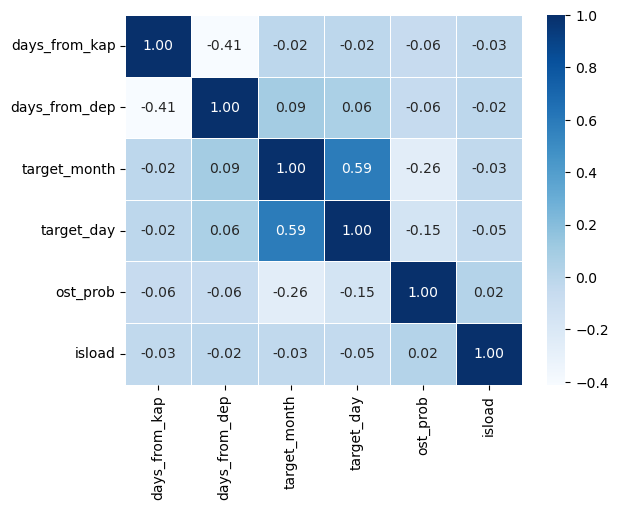

In [58]:
# Correlation between days_from_kap, days_from_dep and target_month, target_day
cr = train[["days_from_kap", "days_from_dep", "target_month", "target_day", "ost_prob", "isload"]].corr()
sns.heatmap(cr, annot=True, fmt=".2f", linewidths=.5, cmap='Blues')
plt.show()

#### Имейте в виду fillna средними значениями

In [61]:
days_from_kap_mean, days_from_dep_mean

(2043.6876631137293, 976.6791346362788)

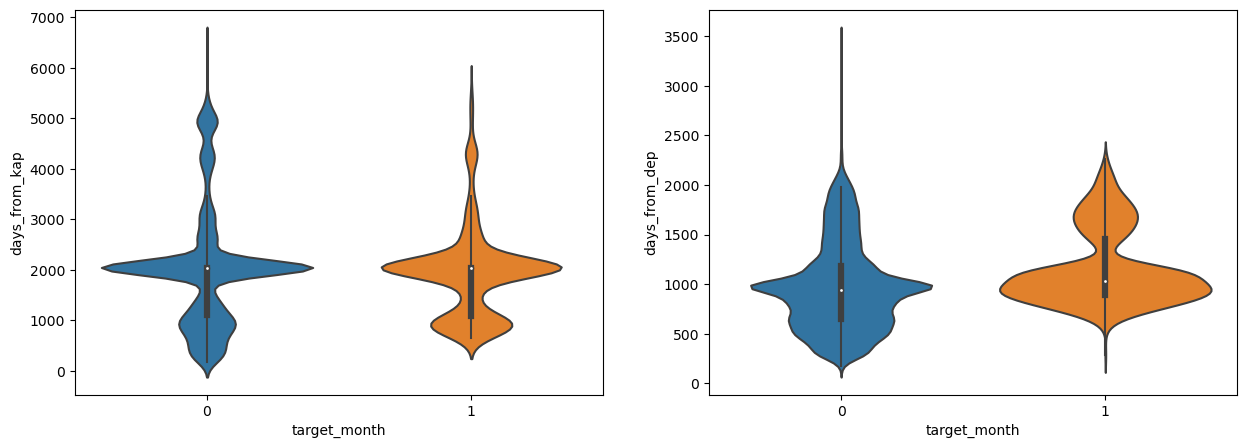

In [59]:
# Violin  between days_from_kap, days_from_dep and target_month, target_day
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.violinplot(x="target_month", y="days_from_kap", data=train, ax=ax[0])
sns.violinplot(x="target_month", y="days_from_dep", data=train, ax=ax[1])
plt.show()


In [79]:
# Fill ost_prob
train['ost_prob'] = train['ost_prob'].fillna(-1)

In [80]:
X = train.drop(["wagnum", "target_month", "target_day", "plan_date", "date_pl_rem", "distance"], axis=1)
y = train[["target_month", "target_day"]]
X.head()

,days_from_kap,days_from_dep,isload,ost_prob
0,1080.000000,1968.0,0,159916
1,851.000000,1767.0,1,4516
2,2043.687663,1034.0,0,1511
3,708.000000,1282.0,0,30223
4,940.000000,1705.0,0,153839


#### Создаем тестовую выборку

In [81]:
test_target = target[target["month"] == "2023-01-01"].drop("month", axis=1)
dis_test = dislok_wagons[dislok_wagons["plan_date"] < "2023-01-01"]

dis_test["days_from_kap"] = (pd.to_datetime("2023-02-01") - dis_test["date_kap"]).dt.days
dis_test["days_from_dep"] = (pd.to_datetime("2023-02-01") - dis_test["date_dep"]).dt.days

# Fill missing values with mean
dis_test['days_from_kap'] = dis_test['days_from_kap'].fillna(-1)
dis_test['days_from_dep'] = dis_test['days_from_dep'].fillna(-1)

dis_test = dis_test.groupby('wagnum').agg({
    'plan_date': ['last'], 
    'days_from_kap': lambda x: x[x != -1].iloc[0] if (x != -1).any() else days_from_kap_mean,
    'days_from_dep': lambda x: x[x != -1].iloc[0] if (x != -1).any() else days_from_dep_mean,
    'date_pl_rem': lambda x: x[x.notnull()].iloc[-1] if x.notnull().any() else None, # поменять
    'distance': 'last',
    'isload': 'last',
    'ost_prob': 'last'
    })


dis_test.columns = ['plan_date', 'days_from_kap', 'days_from_dep', 'date_pl_rem', 'distance', 'isload', 'ost_prob']

C:\Users\mikha\AppData\Local\Temp\ipykernel_624\2085035428.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_test["days_from_kap"] = (pd.to_datetime("2023-02-01") - dis_test["date_kap"]).dt.days
C:\Users\mikha\AppData\Local\Temp\ipykernel_624\2085035428.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_test["days_from_dep"] = (pd.to_datetime("2023-02-01") - dis_test["date_dep"]).dt.days
C:\Users\mikha\AppData\Local\Temp\ipykernel_624\2085035428.py:8: SettingWithCopyWarning: 
A value is trying to

In [82]:
test = pd.merge(test_target, dis_test, how="inner", left_on="wagnum", right_on="wagnum")
test['ost_prob'] = test['ost_prob'].fillna(-1)

X_test = test.drop(["wagnum", "target_month", "target_day", "plan_date", "date_pl_rem", "distance"], axis=1)
y_test = test[["target_month", "target_day"]]

In [83]:
X_test.isna().sum()

days_from_kap    0
days_from_dep    0
isload           0
ost_prob         0
dtype: int64

#### Обучение

In [96]:
# Fit CatBoostClassifier
import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


In [102]:
cat_month = CatBoostClassifier(iterations=1000, learning_rate=0.1, random_seed=42, verbose=False)
cat_month.fit(X, y["target_month"], eval_set=(X_test, y_test["target_month"]), plot=False, early_stopping_rounds=50)
y_pred_cb_month = cat_month.predict(X_test)


print("F1 score: ", f1_score(y_test["target_month"], y_pred_cb_month), '\n', 
      "Precision: ", precision_score(y_test["target_month"], y_pred_cb_month), '\n', 
      "Recall: ", recall_score(y_test["target_month"], y_pred_cb_month), '\n', 
      "Accuracy: ", accuracy_score(y_test["target_month"], y_pred_cb_month), '\n',
      "ROC AUC: ", roc_auc_score(y_test["target_month"], y_pred_cb_month))


F1 score:  0.4822530864197531 
 Precision:  0.6823144104803494 
 Recall:  0.37291169451073986 
 Accuracy:  0.9604980425632119 
 ROC AUC:  0.6819507848656743


F1 score:  0.4840887174541948 
 Precision:  0.33128024637043557 
 Recall:  0.8985680190930787 
 Accuracy:  0.9055132016601419 
 ROC AUC:  0.9022208148225711

In [101]:
cat_day = CatBoostClassifier(iterations=1000, learning_rate=0.1, random_seed=42, verbose=False, auto_class_weights='Balanced')
cat_day.fit(X, y["target_day"], eval_set=(X_test, y_test["target_day"]), early_stopping_rounds=50)
y_pred_cb_day = cat_day.predict(X_test)


print("F1 score: ", f1_score(y_test["target_day"], y_pred_cb_day), '\n',
      "Precision: ", precision_score(y_test["target_day"], y_pred_cb_day), '\n',
      "Recall: ", recall_score(y_test["target_day"], y_pred_cb_day), '\n',
      "Accuracy: ", accuracy_score(y_test["target_day"], y_pred_cb_day), '\n',
      "ROC AUC: ", roc_auc_score(y_test["target_day"], y_pred_cb_day))

F1 score:  0.19999999999999998 
 Precision:  0.1123294998662744 
 Recall:  0.911062906724512 
 Accuracy:  0.9010979307096812 
 ROC AUC:  0.9060118782846718


In [99]:
# Check feature importance
importances = cat_month.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns[i] for i in indices]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. ost_prob (75.625570)
2. days_from_dep (13.129232)
3. days_from_kap (9.900830)
4. isload (1.344368)
